In [77]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml import Pipeline


In [78]:
spark = SparkSession.builder.appName("WaterPotabilityPrediction").getOrCreate()

In [79]:
data = spark.read.csv("Water1.csv", header=True, inferSchema=True)

In [80]:
columns_to_fill = ['ph']

medians = {col: data.approxQuantile(col, [0.5], 0.0)[0] for col in columns_to_fill}


for col, median in medians.items():
    data = data.na.fill({col: median})

In [81]:
from pyspark.sql.functions import col
data = data.withColumn('Hardness_Solids', col('hardness') * col('solids'))

In [82]:
all_columns = data.columns
# The first DataFrame contains the first five variables
first_five_columns = all_columns[:5]  # set columns is 5
df_first_five = data.select(first_five_columns)

# The second DataFrame contains the last six variables
last_six_columns = all_columns[-6:]  # set columns is 6
df_last_six = data.select(last_six_columns)

In [83]:
from pyspark.sql.functions import monotonically_increasing_id

# Add row indexes to two DataFrames
df_first_five = df_first_five.withColumn("row_id", monotonically_increasing_id())
df_last_six = df_last_six.withColumn("row_id", monotonically_increasing_id())
# Merge DataFrame by row index
df_merged = df_first_five.join(df_last_six, "row_id", "inner").drop("row_id")

In [84]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, log1p
from pyspark.sql.types import IntegerType, DoubleType
# Identify numeric columns
numeric_cols = [f.name for f in data.schema.fields if isinstance(f.dataType, (IntegerType, DoubleType))]
# Apply a logarithmic transformation to each numeric column
for col_name in numeric_cols:
    data = data.withColumn(f"{col_name}_log", log1p(col(col_name)))

In [85]:
data1, _ = data.randomSplit([0.8, 0.2], seed=42)
data1 = data1.drop('Potability_log')

In [103]:
data1 = data1.drop("Turbidity_log", "Trihalomethanes", "Organic_carbon")


In [43]:
# Logistic regression
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql.functions import col


indexer = StringIndexer(inputCol="Potability", outputCol="label")
assembler = VectorAssembler(inputCols=[c for c in data1.columns if c != 'Potability'], outputCol="features")
# Defining a logistic regression model
lr = LogisticRegression(featuresCol="features", labelCol="label")

pipeline = Pipeline(stages=[indexer, assembler, lr])
train_data, test_data = data1.randomSplit([0.8, 0.2], seed=42)
model = pipeline.fit(train_data)
predictions = model.transform(test_data)


evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Accuracy: ", accuracy)


predictionAndLabels = predictions.select(['prediction', 'label']).rdd
metrics = MulticlassMetrics(predictionAndLabels)
confusionMatrix = metrics.confusionMatrix().toArray()
print("Confusion Matrix:\n", confusionMatrix)


Accuracy:  0.6475903614457831


/home/ubuntu/.local/lib/python3.10/site-packages/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Confusion Matrix:
 [[198.  21.]
 [ 96.  17.]]


In [74]:
# Classification tree
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

indexer = StringIndexer(inputCol="Potability", outputCol="label")
assembler = VectorAssembler(inputCols=[c for c in data1.columns if c != 'Potability'], outputCol="features")

# Defining a decision tree model
dt = DecisionTreeClassifier(featuresCol="features", labelCol="label", maxDepth=3)


pipeline = Pipeline(stages=[indexer, assembler, dt])

train_data, test_data = data1.randomSplit([0.8, 0.2], seed=42)
model = pipeline.fit(train_data)
predictions = model.transform(test_data)


evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

print("Accuracy: ", accuracy)

predictionAndLabels = predictions.select(['prediction', 'label']).rdd
metrics = MulticlassMetrics(predictionAndLabels)
confusionMatrix = metrics.confusionMatrix().toArray()
print("Confusion Matrix:\n", confusionMatrix)
treeModel = model.stages[-1]  
print(treeModel.toDebugString)

Accuracy:  0.6475903614457831


/home/ubuntu/.local/lib/python3.10/site-packages/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Confusion Matrix:
 [[201.  18.]
 [ 99.  14.]]
DecisionTreeClassificationModel: uid=DecisionTreeClassifier_fc15ad6ca589, depth=3, numNodes=9, numClasses=2, numFeatures=17
  If (feature 4 <= 259.75734258571117)
   If (feature 7 <= 1941762.7242465355)
    Predict: 0.0
   Else (feature 7 > 1941762.7242465355)
    Predict: 1.0
  Else (feature 4 > 259.75734258571117)
   If (feature 4 <= 372.7647732354243)
    Predict: 0.0
   Else (feature 4 > 372.7647732354243)
    If (feature 0 <= 7.501465133532016)
     Predict: 1.0
    Else (feature 0 > 7.501465133532016)
     Predict: 0.0



In [101]:
# Random forest
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

indexer = StringIndexer(inputCol="Potability", outputCol="label")
assembler = VectorAssembler(inputCols=[c for c in data1.columns if c != 'Potability'], outputCol="features")

# Defining a Random Forest Model
rf = RandomForestClassifier(labelCol="label", featuresCol="features", maxDepth=3, numTrees=100)

pipeline = Pipeline(stages=[indexer, assembler, rf])

train_data, test_data = data1.randomSplit([0.8, 0.2], seed=42)
model = pipeline.fit(train_data)
predictions = model.transform(test_data)

evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

print("Accuracy: ", accuracy)

predictionAndLabels = predictions.select(['prediction', 'label']).rdd
metrics = MulticlassMetrics(predictionAndLabels)
confusionMatrix = metrics.confusionMatrix().toArray()
print("Confusion Matrix:\n", confusionMatrix)

f1_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
f1_score = f1_evaluator.evaluate(predictions)
print("F1 Score: ", f1_score)

recall_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")
recall = recall_evaluator.evaluate(predictions)
print("Recall Rate: ", recall)

Accuracy:  0.6626506024096386


/home/ubuntu/.local/lib/python3.10/site-packages/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Confusion Matrix:
 [[204.  15.]
 [ 97.  16.]]
F1 Score:  0.5931984347646997
Recall Rate:  0.6626506024096386


Feature Importances:
Sulfate_log: 0.22912611821650355
Sulfate: 0.17714885741853545
ph: 0.10719473095432809
Solids_log: 0.07999286923041714
ph_log: 0.06920912585759084
Solids: 0.05890796752855553
Hardness: 0.0573219793961942
Hardness_log: 0.04504664541514967
Chloramines_log: 0.036628202705853964
Chloramines: 0.031729152695978154
Hardness_Solids_log: 0.02835329796326184
Conductivity: 0.020788508868997357
Hardness_Solids: 0.015381367943294644
Organic_carbon_log: 0.014179543269187148
Conductivity_log: 0.011541760474400718
Turbidity: 0.009289846302080912
Trihalomethanes_log: 0.008160025759670902


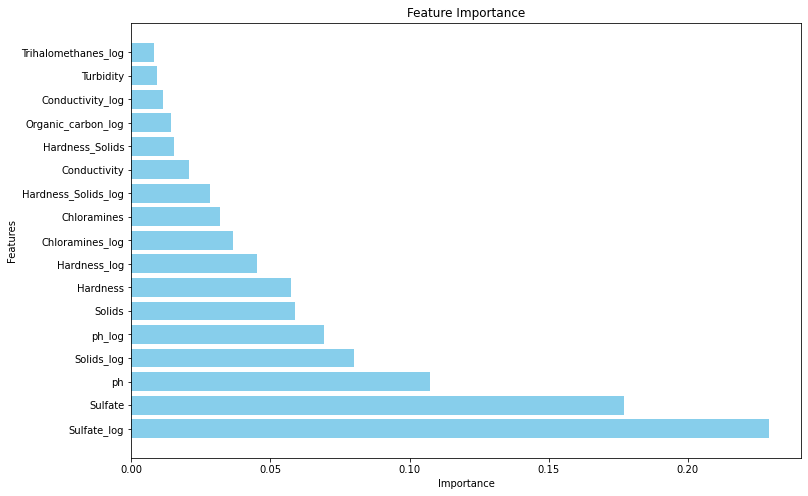

In [100]:
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml import Pipeline

indexer = StringIndexer(inputCol="Potability", outputCol="label")

assembler = VectorAssembler(inputCols=[c for c in data1.columns if c != 'Potability'], outputCol="features")

pipeline = Pipeline(stages=[indexer, assembler])
data1_transformed = pipeline.fit(data1).transform(data1)

from pyspark.ml.classification import RandomForestClassifier

# Creating a Random Forest Classifier
rf = RandomForestClassifier(labelCol="label", featuresCol="features", maxDepth=3, numTrees=100)

model = rf.fit(data1_transformed)

importances = model.featureImportances
feature_names = [c for c in data1.columns if c != 'Potability']

print("Feature Importances:")
sorted_importances = sorted(zip(feature_names, importances), key=lambda x: x[1], reverse=True)
for name, imp in sorted_importances:
    print(f"{name}: {imp}")
    
import matplotlib.pyplot as plt

feature_names, importances = zip(*sorted_importances)

plt.figure(figsize=(12, 8))
plt.barh(feature_names, importances, color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importance')
plt.show()

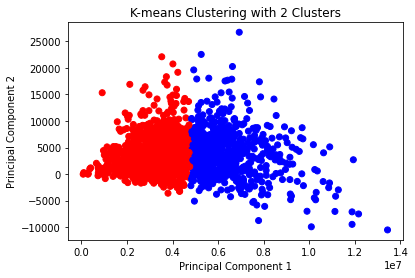

Silhouette with squared euclidean distance = 0.7308337734280587


In [66]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import PCA
import pandas as pd
import matplotlib.pyplot as plt
assembler = VectorAssembler(inputCols=[c for c in data1.columns if c != 'Potability'], outputCol="features")
data1_features = assembler.transform(data1)

# Create a K-means model and set the number of clusters to 2
kmeans = KMeans().setK(2).setSeed(1).setFeaturesCol("features")

model = kmeans.fit(data1_features)

predictions = model.transform(data1_features)

pca = PCA(k=2, inputCol="features", outputCol="pcaFeatures")
pcaModel = pca.fit(data1_features)
pcaResult = pcaModel.transform(predictions).select("pcaFeatures", "prediction")
pandas_df = pcaResult.toPandas()

pandas_df['pca1'] = pandas_df['pcaFeatures'].apply(lambda x: x[0])
pandas_df['pca2'] = pandas_df['pcaFeatures'].apply(lambda x: x[1])

fig, ax = plt.subplots()
colors = {0: 'red', 1: 'blue'}

ax.scatter(pandas_df['pca1'], pandas_df['pca2'], c=pandas_df['prediction'].apply(lambda x: colors[x]))
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('K-means Clustering with 2 Clusters')
plt.show()

from pyspark.ml.evaluation import ClusteringEvaluator

evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(predictions)
print(f"Silhouette with squared euclidean distance = {silhouette}")
